In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from prepare_hess_dataset_large_hdf5 import MyDataset

import torch
from torch import Tensor
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel
from torch.nn import Linear 
from torch.nn import BatchNorm1d, Linear, Dropout

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader, DataListLoader
from torch_geometric.nn import TAGConv, global_add_pool, global_max_pool

from pytorch_lightning.core.lightning import LightningModule
from GNN import GNN
from hess_gnn_large_dataset_single_gpu import GCN
from sklearn.metrics import roc_curve, auc

In [2]:
torch.cuda.empty_cache()

In [3]:
models_base_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/trained_models_single_gpu2/'
plots_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/plots/'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
model = GCN(nb_inputs=3, nb_outputs=1).to(device)
model.load_state_dict(torch.load(models_base_dir + 'model_28_loss0.02_tr0.99_te0.98.pth',map_location=torch.device(device)))
model.eval()

GCN(
  (conv1): TAGConv(3, 128, K=2)
  (conv2): TAGConv(128, 128, K=2)
  (conv3): TAGConv(128, 128, K=2)
  (batchnorm1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=768, out_features=768, bias=True)
  (linear2): Linear(in_features=768, out_features=768, bias=True)
  (linear3): Linear(in_features=768, out_features=768, bias=True)
  (linear4): Linear(in_features=768, out_features=768, bias=True)
  (linear5): Linear(in_features=768, out_features=768, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.3, inplace=False)
  (drop5): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=768, out_features=1, bias=True)
)

In [6]:
indir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/phase2d2_bbruno_large/'
outdir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/phase2d2_dataset_large'
dataset_name = 'test'

In [7]:
dataset = MyDataset(outdir,dataset_name,indir,1)
batch_size = 64

In [8]:
correct = 0 
total_samples = 0
out_pred_list = list()
out_label_list = list()
cr_types = ['gamma','proton']
for idx in range(30,35):
    test_dataset = list()
    for cr_type in cr_types:
        test_dataset += dataset.get(cr_type,idx)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    for bidx, data in enumerate(test_loader):  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data)
        pred = torch.round(torch.sigmoid(out))
        out_pred_list.append(torch.sigmoid(out).detach()) #we don't wanna round this 
        correct += int((pred == data.y.unsqueeze(1)).sum())
        out_label_list.append(data.y.detach())
    total_samples += len(test_loader.dataset)
test_acc = correct/total_samples
print(f'Test Acc: {test_acc:.4f}')
out_pred = torch.cat(out_pred_list,0).squeeze()
out_label = torch.cat(out_label_list,0)

Test Acc: 0.9851


In [9]:
test_pred = out_pred.cpu().detach().numpy()
test_label = out_label.cpu().detach().numpy()

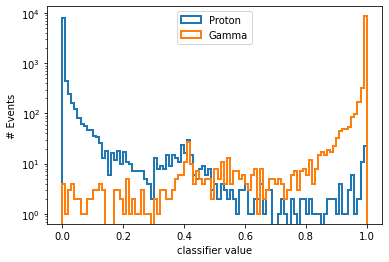

In [10]:
plt.hist(test_pred[test_label==0], bins=100, label='Proton', histtype='step', lw=2);
plt.hist(test_pred[test_label==1], bins=100, label='Gamma', histtype='step', lw=2);
plt.yscale('log')
plt.ylabel('# Events')
plt.xlabel('classifier value')
plt.legend(loc='upper center')
plt.savefig(plots_dir+'classifier_output.pdf',bbox_inches='tight')
plt.savefig(plots_dir+'classifier_output.png',bbox_inches='tight')

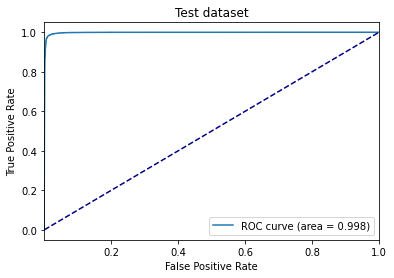

In [13]:
fpr, tpr, thresholds = roc_curve(test_label, test_pred)
roc_auc_train = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.3f)" % roc_auc_train)
plt.plot([0.001, 1], [0.001, 1], color="navy", linestyle="--")
plt.xlim([1.e-4, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('Test dataset')
plt.savefig(plots_dir+'roc_curve.pdf',bbox_inches='tight')
plt.savefig(plots_dir+'roc_curve.png',bbox_inches='tight')